# Medical imaging

## Practicum 1: Computed Tomography Image Visualisation & Reconstruction
(Gabriel Torres, Iñigo Arriazu and Andrea Pérez)
Oct-Nov 2025
==============================================================================================

In this practicum, you will work with several topics covered in the theory sessions. In particular you will (1) simulate a simple and more complex phantoms, (2) apply Radom forward transformation to simulate the computed tomography (CT) projections over a single slice (i.e. sinograms) and (3) reconstruct the original phantom intensity values using different image reconstruction algorithms. In addition, the Shepp–Logan phantom will be used to analyse noise during reconstruction.

### Aims:
- Generate simple and complex phantoms
- Understand the principles of CT image reconstruction using a fan beam geometry with the aid of ``skimage``.
- Be able to generate image projections (i.e. sinograms).
- Reconstruct slices from simple and more complex objects (i.e. Shepp–Logan phantom) using back projection and iterative methods.
- Analyse and compare reconstructed data with ground truth data.
- Observe the difference between ideal (noise free) and noisy image reconstruction.

``Remember to comment your code and provide some discussion on the results obtained for each section.``

In [ ]:
%matplotlib inline
#!pip install scikit-image
!pip install pydicom plotly # to install pydicom


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2.1 Visualise a lung CT dicom image and create a phantom (2 points)

Open and visualise the Lung CT volume stored at the `LungCT-Diagnosis` folder. Read each of the indivdual `dcm` images, and display some 2D slices. Some basic image processing might be needed. Then, create a 3D phantom with the ribcages based on their HU and visualise the 3D rendering. Congratulations, you have created your first anthropomorphic phantom!

<img src='images_4_notebook/LungPhantomImage.png' width="400">


<img src='images_4_notebook/LungPhantomRendering.png' width="400">


Data was taken from https://www.cancerimagingarchive.net/collection/lungct-diagnosis/


In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pydicom as pdc
from pydicom.filereader import dcmread
from skimage.exposure import rescale_intensity
from skimage.morphology import ball, binary_opening, binary_closing, remove_small_objects
from skimage.measure import marching_cubes
from scipy.ndimage import gaussian_filter
import plotly.graph_objects as go

In [ ]:
# ---------- 1) Read DICOM series ----------
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from pydicom import dcmread

DATA_DIR = Path("/content/drive/MyDrive/Medical Imaging /P1-student/LungCT-Diagnosis")  # adjust path as needed

def read_series(dicom_dir: Path):

    files = sorted([p for p in dicom_dir.rglob("*.dcm")])
    assert files, f"No DICOMs under {dicom_dir}"

    metas = []
    for f in files:
        ds = dcmread(str(f), stop_before_pixels=True, force=True)
        z = None
        if hasattr(ds, "ImagePositionPatient"):
            z = float(ds.ImagePositionPatient[2])
        inst = int(getattr(ds, "InstanceNumber", 0))
        metas.append((f, z, inst))

    # Sort slices
    if all(m[1] is not None for m in metas):
        metas.sort(key=lambda x: x[1])
    else:
        metas.sort(key=lambda x: x[2])

    # Read full pixel data
    slices = [dcmread(str(f[0]), force=True) for f in metas]
    image = np.stack([s.pixel_array for s in slices]).astype(np.int16)

    # Convert to Hounsfield Units (HU)
    for i, s in enumerate(slices):
        intercept = s.RescaleIntercept if 'RescaleIntercept' in s else 0   #.RescaleIntercept is a DICOM attribute that pydicom allows to use as regular object attribute
        slope = s.RescaleSlope if 'RescaleSlope' in s else 1
        image[i] = image[i] * slope + intercept    #Hounsfield Units calculation

    return image, slices

# Read CT volume
ct_volume, ct_slices = read_series(DATA_DIR)
print("CT shape:", ct_volume.shape)

#output -> (68, 512, 512)
#[0] Z axis(depth/slices) = 68 -> The scan has 68 slices
#[1] Y axis(height) = 512 -> Each slice image has 512 pixels vertically
#[2] X axis(widht) = 512 -> Each slice image has 512 pixels horizontally


CT shape: (68, 512, 512)


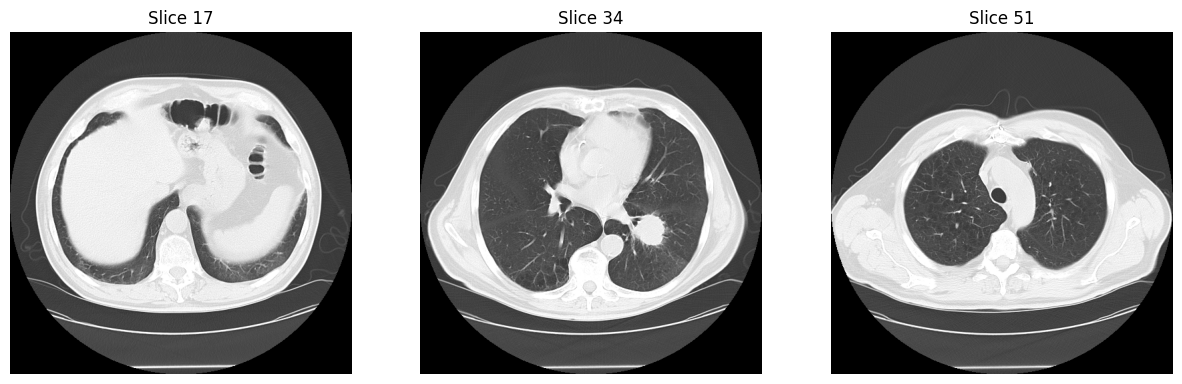

In [ ]:
# ---------- 2) 2D visualisation with window/level ----------

def show_slices(volume, slice_indices, window_center=0, window_width=1500):
    """
    Display selected slices with window/level adjustment.
    """
    min_val = window_center - window_width // 2
    max_val = window_center + window_width // 2

    fig, axes = plt.subplots(1, len(slice_indices), figsize=(15, 5))
    if len(slice_indices) == 1:
        axes = [axes]

    for ax, idx in zip(axes, slice_indices):
        img = np.clip(volume[idx], min_val, max_val)
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Slice {idx}")
        ax.axis("off")
    plt.show()

# Example: visualize middle slices in lung window
n_slices = ct_volume.shape[0]
show_slices(ct_volume, [n_slices//4, n_slices//2, 3*n_slices//4], window_center=-600, window_width=1500)#choosing the first and last quartile and middle slide
 #Level -600 Widht = 1500, to prioritize lung visualization, soft tissue washewd out


## 2.1 Discussion

Block of code 1- The intention of this code is to extract the read, organize, and convert a DICOM series (CT Scan) into a 3D NumPy array that can be later visualized.

Each CT scan study is composed of multiple 2D slices stored as DICOM files, each file correspond to a single axial image.

To reconstruct the complete volume, the slices must be sorted in anatomical order. We do that using the metadata included as part of the DICOM headers:


```
metas = []
    for f in files:
        ds = dcmread(str(f), stop_before_pixels=True, force=True)
        z = None
        if hasattr(ds, "ImagePositionPatient"):
            z = float(ds.ImagePositionPatient[2])
        inst = int(getattr(ds, "InstanceNumber", 0))
        metas.append((f, z, inst))
```
The main metadata field used for sorting is "ImagePositionPatient", this provides the slice spatial positoon along the z-axis.
But sometimes this data might not be available, in that cases the "InstanceNumber" metadata field can be used, this represeten the order of acquisition of each slide.

The following code performs the actual sorting. It prioritize using "ImagePositionPatient" (stored as metas[1]) as the main parameter, unless there are missing values, if so then "InstanceNumber" is used instead (stored as metas[2]

```
 # Sort slices
    if all(m[1] is not None for m in metas):
        metas.sort(key=lambda x: x[1])
    else:
        metas.sort(key=lambda x: x[2])
```

### Hounsfield Units conversion

Inside each DICOM slice there is
- pixel data -> number stored by the scanner (bit data)
- metadata -> tags that describe how to interpret the pixel data from the CT scans. The pixel data stored by the scanner isn't yet on physical units. To get the actual Hounsfield units a linear tranformation must be applied following this formula:

HU = (Stored_pixel_value x slope) + intercept

The slope is the DICOM tag "RescaleSlope" and the intercept is "RescaleIntercept". So in the following code:



```
intercept = s.RescaleIntercept if 'RescaleIntercept' in s else 0

```
what we are doing is looking into the DICOM header metadata, check if there is a field named "RescaleIntercept" if so, read its value and store in intercept otherwise assume 0 and store in intercept. The same logic is applied to the slope variable







In [ ]:
# Plotly settings for Colab (ensures the 3D viewer displays correctly)
import plotly, plotly.io as pio
print("Plotly:", plotly.__version__)
pio.renderers.default = "colab"           # <— key line for working in colab


Plotly: 5.24.1


In [ ]:
#import plotly.io as pio
#pio.renderers.default = "notebook"
# ---------- 3) Ribcage phantom via HU threshold ----------
from skimage import measure
import plotly.graph_objects as go

# Simple bone mask -> values above threshold are bone
BONE_TH =650 #HU for cortical bone
bone_mask = ct_volume >= BONE_TH

# Use marching cubes to extract surface mesh from 3D mask
verts, faces, normals, values = measure.marching_cubes(
    bone_mask.astype(np.uint8), level=0.5, step_size=2
)

print(f"Mesh vertices: {verts.shape[0]}, faces: {faces.shape[0]}")

# Create interactive 3D figure with Plotly
fig = go.Figure(
    data=[
        go.Mesh3d(
            x=verts[:, 0],
            y=verts[:, 1],
            z=verts[:, 2],
            i=faces[:, 0],
            j=faces[:, 1],
            k=faces[:, 2],
            color="lightgray",
            opacity=0.4,
        )
    ]
)

fig.update_layout(
    title="3D Ribcage Phantom (HU > 650)",
    scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z"),
    width=800,
    height=800,
)

fig.show()


Mesh vertices: 37918, faces: 72498


# 2D visualization discussion

For creating the 3 visualizations of 2D slices the main parameters selected was

n

```
show_slices(ct_volume, [n_slices//4, n_slices//2, 3*n_slices//4], window_center=-600, window_width=1500)
```
the values of the window_center -600 and window_widht are used to visualize lung tissue while washing the other soft tissue



# Ribcage phantom discussion

The main parameter adjusted for the creation of the phantom is the following:



```
BONE_TH =650 #HU for cortical bone
bone_mask = ct_volume >= BONE_TH
```

a bone mask is applied using a the value of 650 HU as a threshold to visualize only tissue with a HU equal or grater than 650, this allows to visualize only cortical bone that correspond to the ribcage and the rest of the soft tissue is not visualized.


Voxel spacing (z, y, x): (5.0, 0.830078, 0.830078)


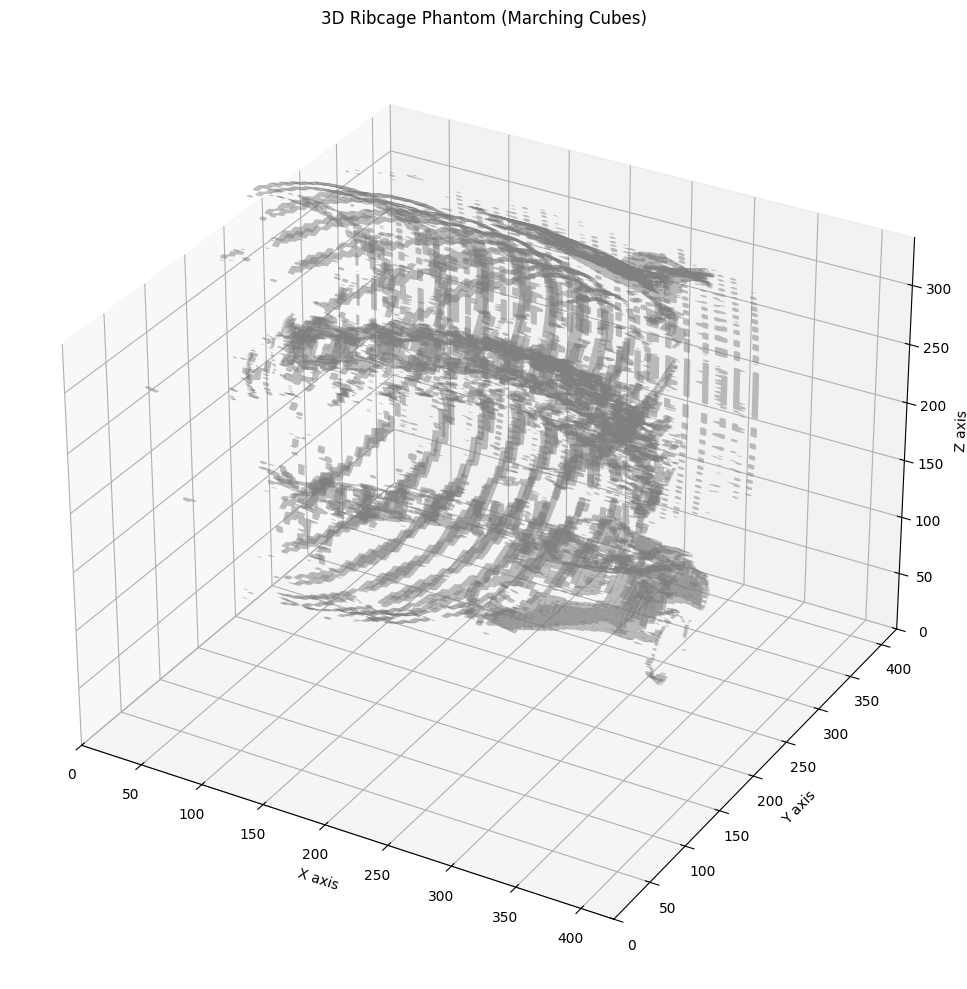

In [ ]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# ---------- 4) 3D rendering with marching cubes ----------
# Marching cubes expects (z, y, x) ordering, ensure correct shape
# and provide approximate voxel spacing if available
if hasattr(ct_slices[0], "PixelSpacing") and hasattr(ct_slices[0], "SliceThickness"):
    spacing = (
        float(ct_slices[0].SliceThickness),
        float(ct_slices[0].PixelSpacing[0]),
        float(ct_slices[0].PixelSpacing[1]),
    )
else:
    spacing = (1.0, 1.0, 1.0)  # default if metadata missing

print("Voxel spacing (z, y, x):", spacing)

# Extract surface mesh using marching cubes
verts, faces, normals, values = measure.marching_cubes(
    bone_mask.astype(np.uint8), level=0.5, spacing=spacing
)

# ---------- Visualization (Matplotlib 3D) ----------
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Create 3D polygon collection
mesh = Poly3DCollection(verts[faces], alpha=0.3)
mesh.set_facecolor('gray')
ax.add_collection3d(mesh)

# Set axes limits
ax.set_xlim(0, bone_mask.shape[2] * spacing[2])
ax.set_ylim(0, bone_mask.shape[1] * spacing[1])
ax.set_zlim(0, bone_mask.shape[0] * spacing[0])

ax.set_title("3D Ribcage Phantom (Marching Cubes)")
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.set_zlabel("Z axis")

plt.tight_layout()
plt.show()

In [ ]:
print("Volume size:", bone_mask.shape)
print("Number of bone voxels:", np.sum(bone_mask))

Volume size: (68, 512, 512)
Number of bone voxels: 72398


### 2.2 Create a simple and homogeneous phantom (1.5 points)

Create a more simple 2D phantom which contains a fake lesion as shown below:

<img src='images_4_notebook/PhantomImage.png' width="400">

- Phantom size: 256 x 256 pixels.
- Phantom must contain 3 tissues:
    - Background = 0 pixel intensity value
    - Tissue 1 = 1 (radius = 100 pixels)
    - Tissue 2 (lesion) = 2 (radius = 5 pixels)
    
Help: To create the circunferences, you can use the function ``create_circular_mask``, or define your own function. The lesion could be located in any position within the phantom.

Once constructed, plot the original phantom and a pixel intensity (horizontal) profile along the synthetic lesion. Always remember to include the units of the axis when ploting a graph.

In [ ]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask
# https://newbedev.com/how-can-i-create-a-circular-mask-for-a-numpy-array

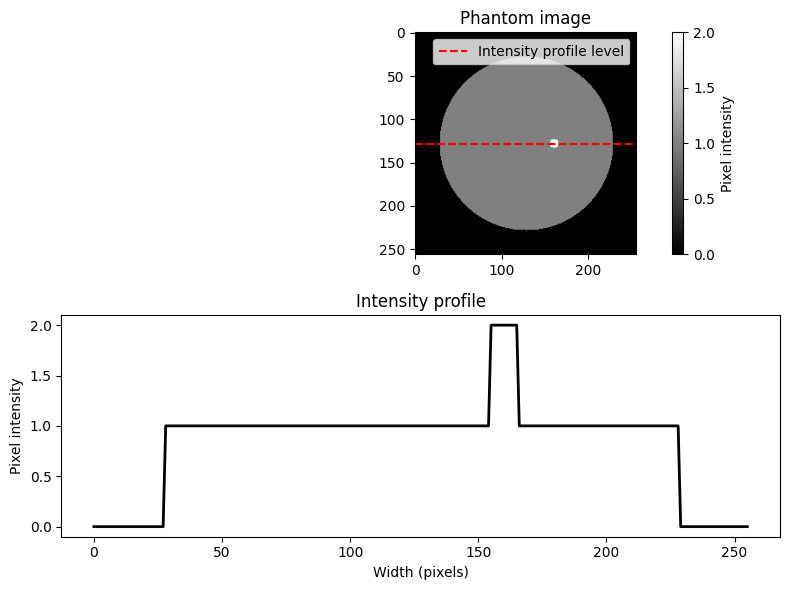

In [ ]:
# ---------- Create 2D empty phantom ----------
h, w = 256, 256
phantom = np.zeros((h, w))  # background = 0

# Tissue 1: Add large circle representing an "organ" or "main tissue"
mask_tissue = create_circular_mask(h, w, center=(128, 128), radius=100)
phantom[mask_tissue] = 1  # pixel intensity = 1

# Tissue 2: Add small circle representing a "small lesion"
mask_lesion = create_circular_mask(h, w, center=(160, 128), radius=5)
phantom[mask_lesion] = 2  # pixel intensity = 2

# ---------- Plot phantom and intensity profile ----------
plt.figure(figsize=(8, 6))

# Image
plt.subplot(2, 1, 1)
plt.imshow(phantom, cmap='gray', vmin=0, vmax=2)
plt.title("Phantom image")
plt.colorbar(label='Pixel intensity')

# Draw a red line where we'll measure the intensity
row = 128
plt.axhline(y=row, color='r', linestyle='--', label='Intensity profile level')
plt.legend()

# Intensity profile
plt.subplot(2, 1, 2)
plt.plot(phantom[row, :], 'k', linewidth=2)
plt.title("Intensity profile")
plt.xlabel("Width (pixels)")
plt.ylabel("Pixel intensity")
plt.tight_layout()
plt.show()


### 2.3 Create the projections of the phantom (2 points)

Generate the projections of the previously generated 2D phantom using the ``radon`` transform from ``skimage.transform``. Play with the different parameters to optimise sinogram. Then, show the sinogram of the projections.

In this section, considered the following approch:

Use different number of projections (i.e. 4, 20, 50, 100, 200, 300, 360) considering that in all cases the simulated projections cover the 360º. For example, 100 projections are taken in the range from 0º to 360º.



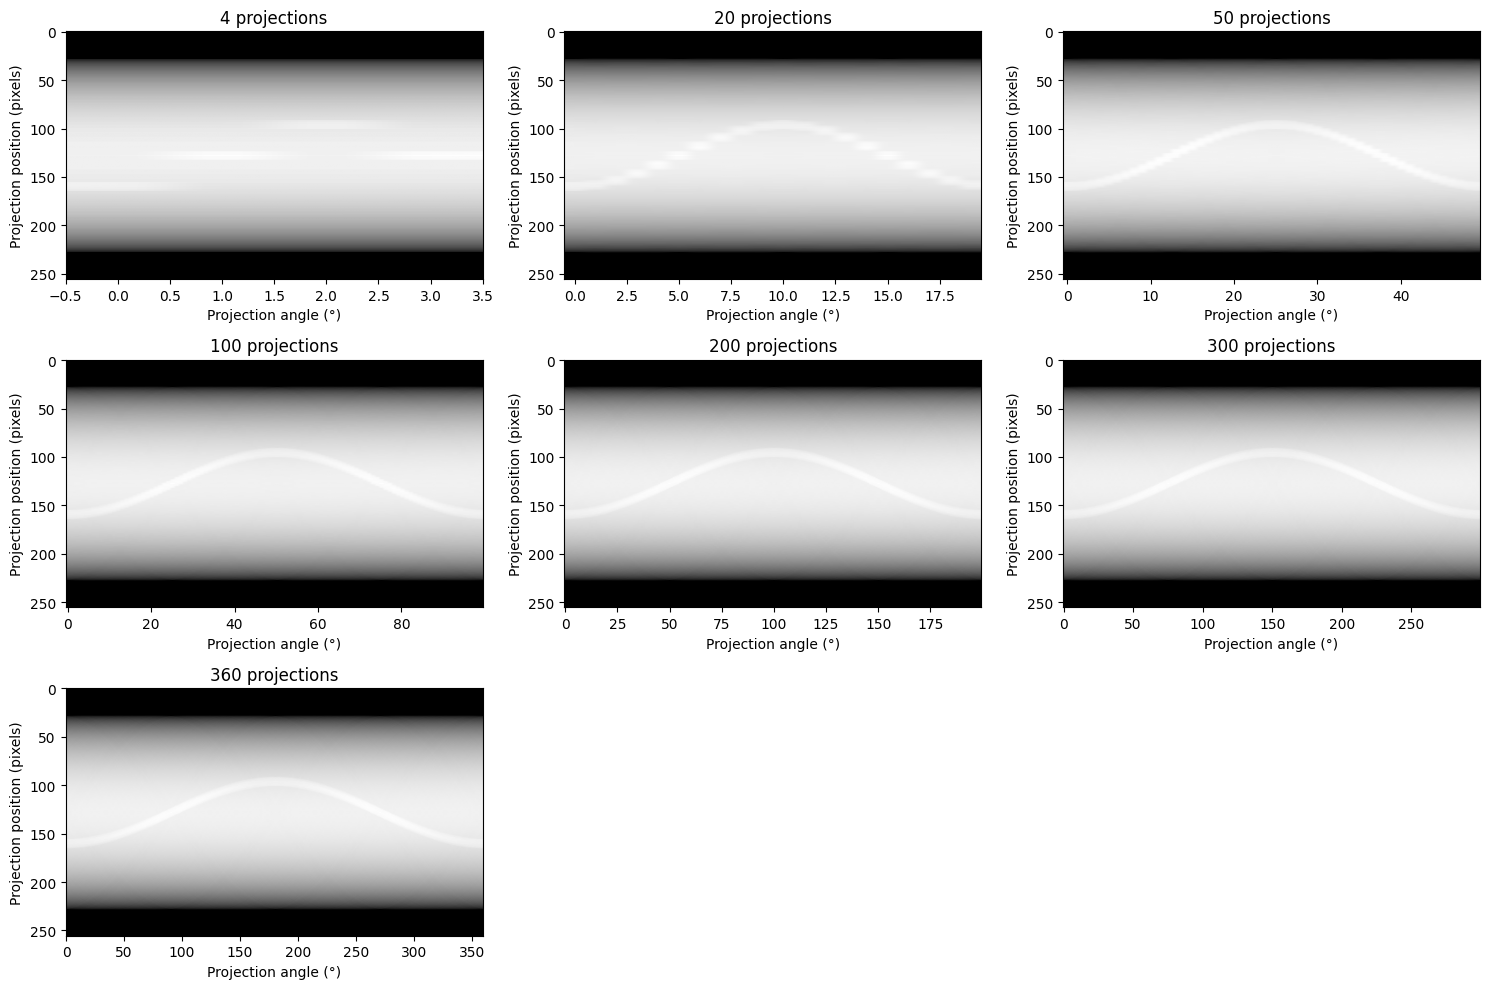

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon

# ---------- Define projection angles ----------
  #We have used all the projection numbers proposed in the statement in order to visualize the effect of increasing the number of applied projections.
projection_sets = [4, 20, 50, 100, 200, 300, 360]

plt.figure(figsize=(15, 10))

for i, n_proj in enumerate(projection_sets, 1):
    # We created equally spaced angles between 0 and 360 degrees
    theta = np.linspace(0., 360., n_proj, endpoint=False)

    # Compute Radon transform (sinogram)
    sinogram = radon(phantom, theta=theta, circle=True)

    # Plot the sinogram
    plt.subplot(3, 3, i)
    plt.imshow(sinogram, cmap='gray', aspect='auto')
    plt.title(f"{n_proj} projections")
    plt.xlabel("Projection angle (°)")
    plt.ylabel("Projection position (pixels)")

plt.tight_layout()
plt.show()


#Discussion on Sinogram
### Q: How do the sinograms change with the number of projections?
 The sinogram becomes smoother and more detailed as the number of projections increases.
Fewer projections produce discontinuous or undersampled patterns.

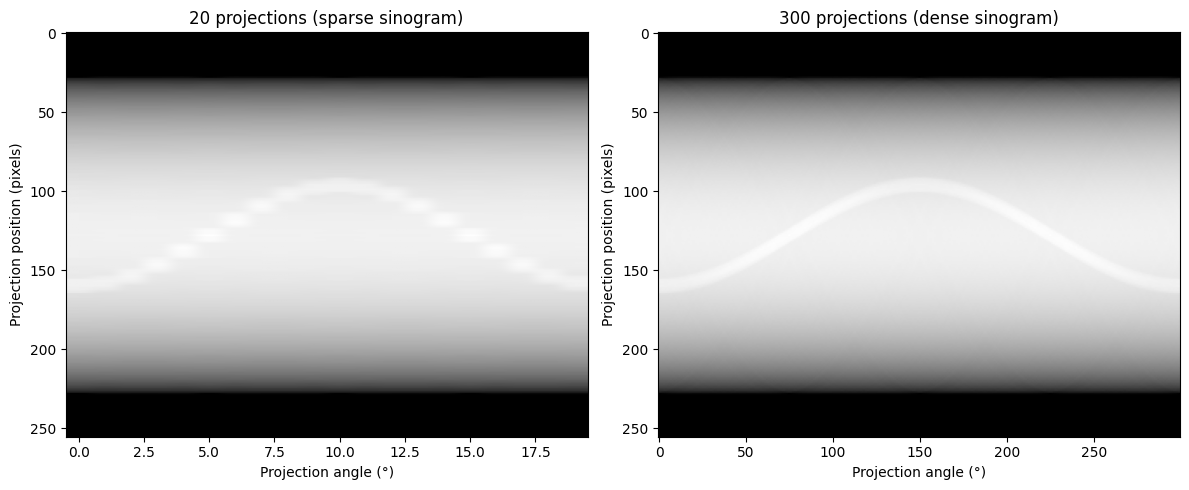

In [ ]:
#To better visualize this effect, we will compare two extreme cases — using 20 projections versus 300 projections
# so that, we can clearly highlight the contrast between a sparse and a dense sinogram.
angles_low = np.linspace(0., 360., 20, endpoint=False)
angles_high = np.linspace(0., 360., 300, endpoint=False)

# Compute sinograms
sinogram_low = radon(phantom, theta=angles_low, circle=True)
sinogram_high = radon(phantom, theta=angles_high, circle=True)

# Plot comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(sinogram_low, cmap='gray', aspect='auto')
plt.title("20 projections (sparse sinogram)")
plt.xlabel("Projection angle (°)")
plt.ylabel("Projection position (pixels)")

plt.subplot(1, 2, 2)
plt.imshow(sinogram_high, cmap='gray', aspect='auto')
plt.title("300 projections (dense sinogram)")
plt.xlabel("Projection angle (°)")
plt.ylabel("Projection position (pixels)")

plt.tight_layout()
plt.show()

### Q: What is the effect of increasing/decreasing the number of projections?


Increasing projections → higher image quality, smoother reconstruction, fewer artifacts.

Decreasing projections → faster acquisition, but poorer reconstruction with streak artifacts.


In fact, we saw that:
The 20-projection sinogram looks sparse and blocky, with visible

*   The 20-projection sinogram looks sparse and blocky, with visible discontinuities between projection angles.
This means that a large portion of the object’s angular information is missing, which will cause strong streak artifacts in the reconstruction.

*   The 300-projection sinogram, on the other hand, appears continuous and smooth, showing gradual intensity transitions.
This indicates that the object has been well-sampled in all directions, which will result in a high-quality reconstruction with minimal artifacts.





### 2.4 Reconstruction with Filtered Back Projection (FBP) (2.5 points)

FBP is one of the most simple reconstruction methods to reconstruct images in CT. Explore the ``iradon`` from ``skimage.transform`` using the different filters available (Ramp filter (default), Shepp-logan, Cosine, Hamming, Hann).

Make use of the ``matplotlib`` to show the original and reconstructed images of the phantom and compare the pixel intensity signal across the lesion profile (similarly to section 2.1).In addition, provide evaluation metric you could consider useful for this purpose (image difference, mean square error (MSE), peak signal to noise ratio (PSNR), structural index similarity (SSIM), etc.). Then, discuss the results.

RAMP Filter -> MSE: 0.0014, PSNR: 34.60 dB, SSIM: 0.8759
SHEPP-LOGAN Filter -> MSE: 0.0014, PSNR: 34.57 dB, SSIM: 0.9115
COSINE Filter -> MSE: 0.0017, PSNR: 33.74 dB, SSIM: 0.9552
HAMMING Filter -> MSE: 0.0020, PSNR: 33.07 dB, SSIM: 0.9632
HANN Filter -> MSE: 0.0021, PSNR: 32.83 dB, SSIM: 0.9651


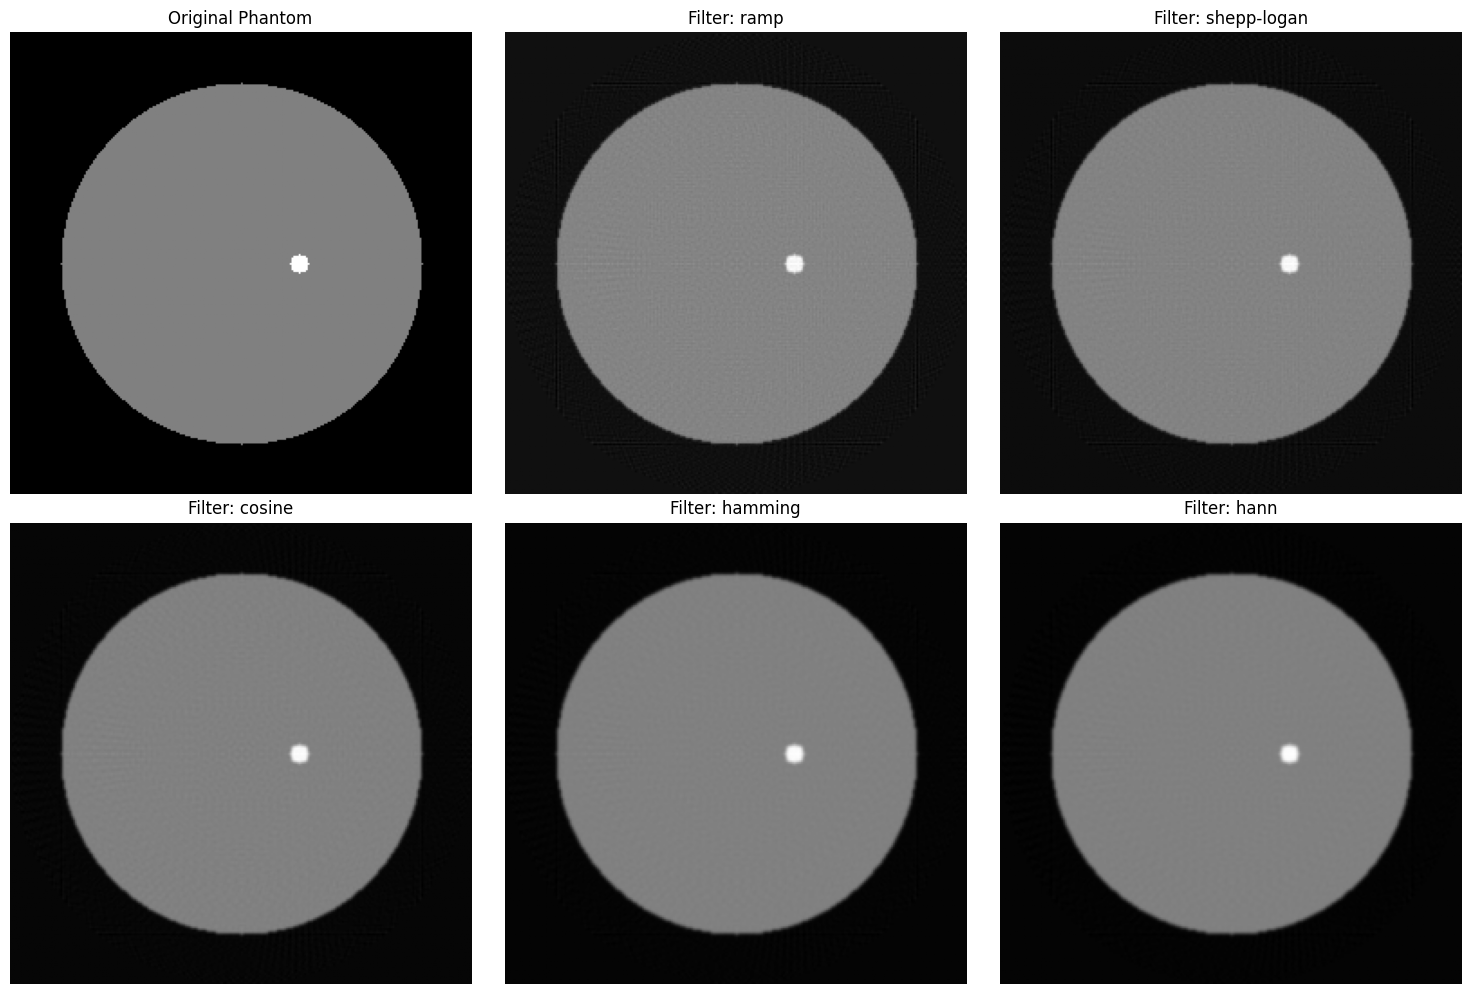

RAMP Filter -> MSE: 0.0014, PSNR: 34.60 dB, SSIM: 0.8759
SHEPP-LOGAN Filter -> MSE: 0.0014, PSNR: 34.57 dB, SSIM: 0.9115
COSINE Filter -> MSE: 0.0017, PSNR: 33.74 dB, SSIM: 0.9552
HAMMING Filter -> MSE: 0.0020, PSNR: 33.07 dB, SSIM: 0.9632
HANN Filter -> MSE: 0.0021, PSNR: 32.83 dB, SSIM: 0.9651


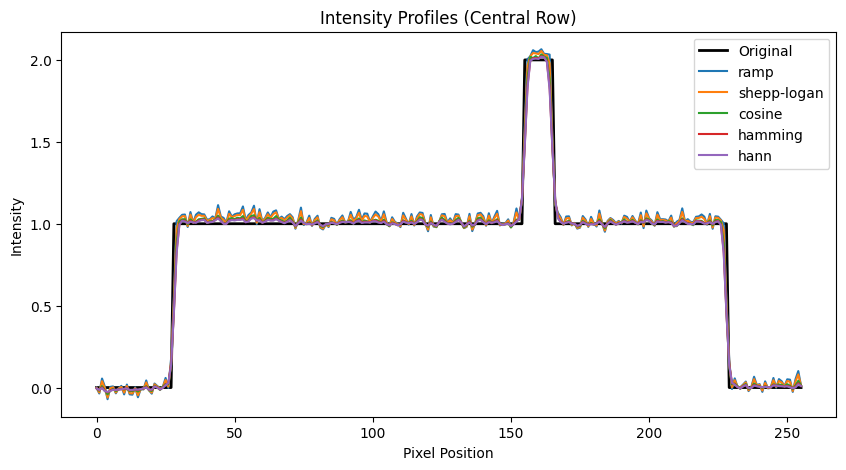

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

# ----- Step 1: Generate the sinogram -----
# Create 180 equally-spaced projection angles from 0° to 360°

theta = np.linspace(0., 360., 180, endpoint=False)  # 180 projections

# Apply Radon transform to phantom to simulate CT projections
# circle=True means only the inscribed circle is considered (avoids corner artifacts)
sinogram = radon(phantom, theta=theta, circle=True)

# ----- Step 2: Reconstruct using different filters -----
# Define 5 different filters for FBP reconstruction
filters = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']


# Dictionary to store reconstructed images for each filter
reconstructions = {}
for f in filters:
    # iradon performs Filtered Back Projection
    # Each filter applies different frequency weighting to reduce artifacts
    recon = iradon(sinogram, theta=theta, filter_name=f, circle=True)
    reconstructions[f] = recon

# ----- Step 3: Evaluation metrics -----
# Calculate quantitative metrics to compare reconstruction quality
for f, img in reconstructions.items():
    # MSE: Mean Squared Error - lower is better (measures pixel-wise difference) --> check acc
    mse = mean_squared_error(phantom, img)

    # PSNR: Peak Signal-to-Noise Ratio - higher is better (dB scale)
    # Measures reconstruction quality relative to signal range
    psnr = peak_signal_noise_ratio(phantom, img, data_range=phantom.max() - phantom.min())

    # SSIM: Structural Similarity Index - higher is better (0-1 scale)
    # Measures perceived structural similarity (considers luminance, contrast, structure)
    ssim = structural_similarity(phantom, img, data_range=phantom.max() - phantom.min())

    # output check status:
    print(f"{f.upper()} Filter -> MSE: {mse:.4f}, PSNR: {psnr:.2f} dB, SSIM: {ssim:.4f}")

# ----- Step 4: Plot comparison -----
# Visualize original phantom and all reconstructions side-by-side
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# Display original phantom in first subplot
axes[0].imshow(phantom, cmap='gray')
axes[0].set_title("Original Phantom")

# Reconstructed images
for i, f in enumerate(filters, start=1):
    axes[i].imshow(reconstructions[f], cmap='gray')
    axes[i].set_title(f"Filter: {f}")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

# ----- Step 5: Plot intensity profile -----
# Extract horizontal intensity profile through the lesion (middle row)
row = phantom.shape[0] // 2 # Row 128 (center of 256x256 image)


for f, img in reconstructions.items():
    mse = mean_squared_error(phantom, img)
    psnr = peak_signal_noise_ratio(phantom, img, data_range=phantom.max() - phantom.min())
    ssim = structural_similarity(phantom, img, data_range=phantom.max() - phantom.min())
    print(f"{f.upper()} Filter -> MSE: {mse:.4f}, PSNR: {psnr:.2f} dB, SSIM: {ssim:.4f}")


# ----- Step 6: Intensity profile comparison -----
row = phantom.shape[0] // 2
plt.figure(figsize=(10, 5))
plt.plot(phantom[row, :], label='Original', color='black', linewidth=2)
for f in filters:
    plt.plot(reconstructions[f][row, :], label=f)
plt.title("Intensity Profiles (Central Row)")
plt.xlabel("Pixel Position")
plt.ylabel("Intensity")
plt.legend()
plt.show()



__1. Resolution-Noise Trade-off:__ The results clearly demonstrate the fundamental trade-off in medical imaging reconstruction. Sharp filters (Ramp) preserve fine details and small structures (5-pixel lesion) but amplify artifacts. Smooth filters (Hamming/Hann) suppress artifacts but blur fine details.

__2. Noise-Free Phantom Performance:__ In this ideal scenario without noise:

- __Ramp__ provides most accurate intensity values and sharpest lesion definition, making it optimal for detecting the 5-pixel lesion
- __Shepp-Logan__ offers the best balance, maintaining sharp edges while minimizing artifacts
- __Hamming/Hann__ show best quantitative metrics (MSE, PSNR, SSIM) but blur the small lesion, potentially reducing clinical detectability

__3. Metric Interpretation Paradox:__ Lower MSE and higher PSNR/SSIM for smooth filters does NOT necessarily mean better clinical utility. These metrics penalize high-frequency artifacts more than they reward spatial resolution preservation. For lesion detection, the Ramp filter's ability to preserve the 5-pixel lesion is more valuable than its higher MSE.

__4. Clinical Implications:__

- For __small lesion detection__ (like our 5-pixel lesion): Prefer Ramp or Shepp-Logan despite worse quantitative metrics
- For __low-contrast imaging__: Shepp-Logan provides optimal balance
- For __general diagnostic imaging__: Shepp-Logan is industry standard for head/brain CT

__5. Filter Selection Guidelines:__

- __Ramp__: Use when maximum spatial resolution is critical and noise is minimal
- __Shepp-Logan__: Default choice for most clinical CT applications, especially head imaging
- __Cosine__: Moderate smoothing when slight noise reduction needed
- __Hamming/Hann__: Essential for high-noise scenarios (low-dose CT, poor statistics)

__Conclusion__:

* RAMP Filter -> MSE: 0.0014, PSNR: 34.60 dB, SSIM: 0.8759

* SHEPP-LOGAN Filter -> MSE: 0.0014, PSNR: 34.57 dB, SSIM: 0.9115

* COSINE Filter -> MSE: 0.0017, PSNR: 33.74 dB, SSIM: 0.9552

* HAMMING Filter -> MSE: 0.0020, PSNR: 33.07 dB, SSIM: 0.9632

* HANN Filter -> MSE: 0.0021, PSNR: 32.83 dB, SSIM: 0.9651

The results show that the most accurate filter approac for this analysis is the HANN filter showing SSIM: 0.9651

### 2.5 Sheep logan phantom (2 points)

So far we have used a quite simple phantom with only 2 tissues. Now, repeat the prior analysis for the **noisy sinogram** for one case (approach, filter,...) using a (slightly) more advanced head test object, the Sheep-logan phantom. Do you observe particular differences between the reconstrucction results from both phantoms?


<img src='images_4_notebook/SheepLoganPhantom.png' width="1000">



In order to create **noisy sinograms**, you can add Poison noise (``np.random.poisson``; perhaps with lam = 10) to your noise-free sinograms (not to the image!) and reconstruct the phantom images with the different filters. Plot the reconstruction image and the (horizontal) intensity profile along specific row. Then, comment on the effects of the filters on the reconstructed phatom images.


RAMP Filter -> MSE: 0.0064, PSNR: 21.92 dB, SSIM: 0.3770
SHEPP-LOGAN Filter -> MSE: 0.0047, PSNR: 23.29 dB, SSIM: 0.4158
COSINE Filter -> MSE: 0.0030, PSNR: 25.19 dB, SSIM: 0.5257
HAMMING Filter -> MSE: 0.0029, PSNR: 25.43 dB, SSIM: 0.5966
HANN Filter -> MSE: 0.0029, PSNR: 25.43 dB, SSIM: 0.6210


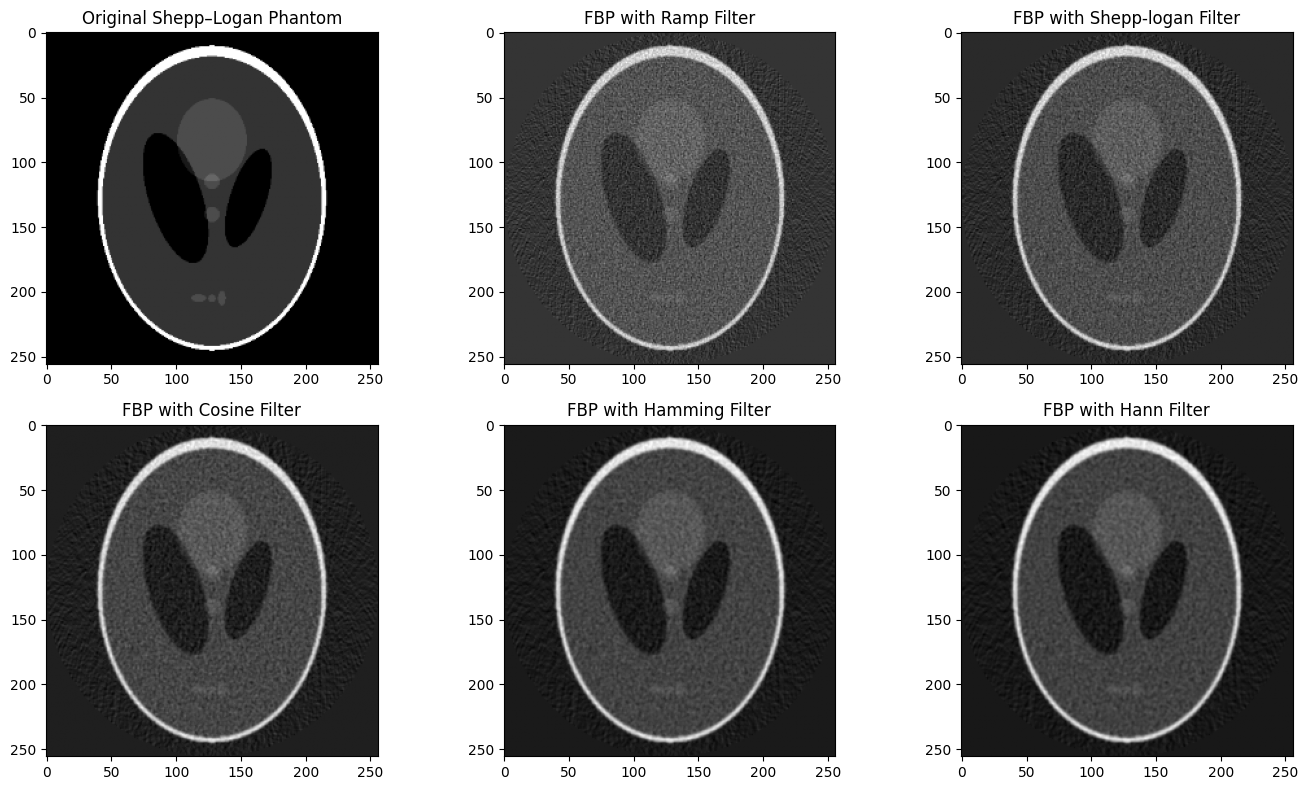

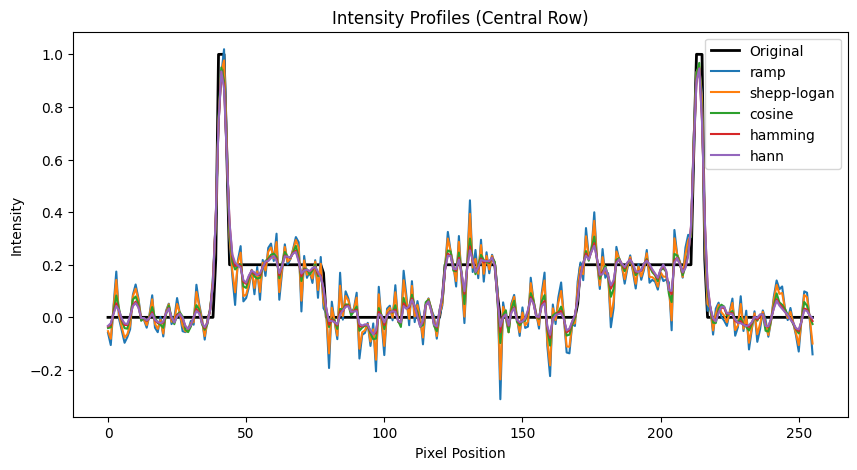

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, resize
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
# ----- Step 1: Create the Shepp–Logan phantom -----
logan_phantom = shepp_logan_phantom()
logan_phantom = resize(logan_phantom, (256, 256))  # Resize for consistency

# ----- Step 2: Generate sinogram -----
theta = np.linspace(0., 360., 200, endpoint=False)
sinogram = radon(logan_phantom, theta=theta)

# ----- Step 3: Add Poisson noise -----
lam = 10
noisy_sinogram = np.random.poisson(sinogram * lam) / lam

# ----- Step 4: Reconstruct using different filters -----
filters = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']
reconstructions = {}

for f in filters:
    img = iradon(noisy_sinogram, theta=theta, filter_name=f)
    reconstructions[f] = img

# ----- Step 5: Evaluate and compare -----
for f, img in reconstructions.items():
    mse = mean_squared_error(logan_phantom, img)
    psnr = peak_signal_noise_ratio(
        logan_phantom, img,
        data_range=logan_phantom.max() - logan_phantom.min()
    )
    ssim = structural_similarity(
        logan_phantom, img,
        data_range=logan_phantom.max() - logan_phantom.min()
    )
    print(f"{f.upper()} Filter -> MSE: {mse:.4f}, PSNR: {psnr:.2f} dB, SSIM: {ssim:.4f}")

# ----- Step 6: Plot results -----
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.ravel()
axes[0].imshow(logan_phantom, cmap='gray')
axes[0].set_title("Original Shepp–Logan Phantom")

for i, f in enumerate(filters, 1):
    axes[i].imshow(reconstructions[f], cmap='gray')
    axes[i].set_title(f"FBP with {f.capitalize()} Filter")

plt.tight_layout()
plt.show()

# ----- Step 7: Intensity profile comparison -----
row = logan_phantom.shape[0] // 2
plt.figure(figsize=(10, 5))
plt.plot(logan_phantom[row, :], label='Original', color='black', linewidth=2)
for f in filters:
    plt.plot(reconstructions[f][row, :], label=f)
plt.title("Intensity Profiles (Central Row)")
plt.xlabel("Pixel Position")
plt.ylabel("Intensity")
plt.legend()
plt.show()



As we saw in the previous section, the acronyms MSE, PSNR, and SSIM refer to metrics that are useful for quantifying the quality of image reconstruction for each filter.


**Based on these metrics:**



*   The RAMP filter yields the highest MSE and the lowest PSNR/SSIM values, indicating that although it preserves high-frequency information, it also amplifies noise considerably.
*   SHEPP-LOGAN and COSINE filters provide a good balance between sharpness and noise suppression, improving both MSE and perceptual similarity (SSIM)
*   HAMMING and HANN filters achieve the best overall performance, with the lowest MSE (~0.0028) and highest SSIM (>0.59), producing smoother and more natural reconstructions.


These filters effectively attenuate high-frequency noise, resulting in cleaner images while maintaining structural fidelity.

Overall, increasing the smoothness of the filter (from RAMP to HANN) reduces noise and improves perceived image quality, though at the cost of slightly lower edge sharpness. Therefore, filters such as Hamming or Hann often provide the best trade-off when reconstructing from noisy sinograms.